# What are the effects of suggested combinatorial therapies?

In [1]:
import pandas as pd
import numpy as np
import json
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time
import glob

params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
    'savefig.facecolor':'white'
   }

mpl.rcParams.update(params)


import random 
random.seed(12357)
np.random.seed(12357)


import pprint 
ppdict = pprint.PrettyPrinter(indent=4, sort_dicts=False)


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


timestr = time.strftime("%Y%m%d%H%M")
print(timestr)

202310171607


In [2]:
sol_saveat_dt = [1,1e-4][0]

print(sol_saveat_dt)

inpath = "output/"
outpath = "figures/fig4b/" 

1


In [3]:
##############################################
# set to True to save fig

savefigures = True #False #True 

##############################################

In [4]:
! ls -lh output | grep "_u\." | grep "sim_" | wc -l

190


In [5]:
print(len(glob.glob(inpath+"*_u.csv"))) 

190


In [6]:
input_file_ids = [i.rstrip("_u.csv") for i in glob.glob(inpath+"*_u.csv")]


input_file_ids = sorted(input_file_ids)

In [7]:
input_dfs = []

for fid in input_file_ids:

    dfn = fid + "_u.csv"
    tfn = fid + "_t.csv"
    nfn = fid + "_unames.csv"
    
    df = pd.read_csv(dfn,header=None)
    tf = pd.read_csv(tfn,header=None)
    nf = pd.read_csv(nfn,header=None)
    
    df.columns = [i[:-1] for i in nf[0].values.tolist() ]
    
    df['time_s'] = tf[0].copy()
    df['condition'] = fid.replace("output/sim_","").split("_extraTag",1)[0]
    
    input_dfs.append(df)
    
input_df = pd.concat(input_dfs, axis=0, ignore_index=True)

In [8]:
print(input_df.shape)

(58900, 185)


In [9]:
input_df = input_df.reindex(sorted(input_df.columns), axis=1)

In [10]:
input_df = input_df.loc[input_df['time_s']>180,:]
input_df = input_df.reset_index(drop=True)

In [11]:
input_df.head(3)

,ADP_a,ADP_i_a,ADP_i_n,ADP_mi_a,ADP_mi_n,ADP_mx_a,ADP_mx_n,ADP_n,ADPmito_a,ADPmito_n,...,f26bp_a,h,hIP3Ca_a,mGluRboundRatio_a,n,nBK_a,pgate,sTRP_a,time_s,vV
0,0.045,0.045969,0.057954,0.045225,0.056787,1.152120,1.131716,0.047784,1.759665,1.856772,...,0.012238,0.991528,0.653282,0.0,0.021990,0.000007,0.023936,0.001238,181.0,0.0237
1,0.045,0.045971,0.057954,0.045227,0.056787,1.152133,1.131715,0.047784,1.759688,1.856772,...,0.012238,0.991528,0.653285,0.0,0.021989,0.000007,0.023936,0.001238,182.0,0.0237
2,0.045,0.045973,0.057954,0.045230,0.056787,1.152145,1.131715,0.047784,1.759712,1.856771,...,0.012239,0.991528,0.653289,0.0,0.021989,0.000007,0.023936,0.001238,183.0,0.0237


In [12]:
all_cnds_l = sorted(input_df['condition'].unique())
len(all_cnds_l)

190

### Metric to rank therapies efficiencies

In [13]:
ATPsNADs = [i[0:-1] for i in [ 

    'ATP_a0',
    'ATP_i_a0',
    'ATP_i_n0',
    'ATP_mi_a0',
    'ATP_mi_n0',
    'ATP_mx_a0',
    'ATP_mx_n0',
    'ATP_n0',
    'ATPmito_a0',
    'ATPmito_n0',

    'NADH_a0',
    'NADH_n0',
    'NADHmito_a0',
    'NADHmito_n0',
    'NADPH_a0',
    'NADPH_n0'
    
]]

ATPs  = [i[0:-1] for i in [ 

    'ATP_a0',
    'ATP_i_a0',
    'ATP_i_n0',
    'ATP_mi_a0',
    'ATP_mi_n0',
    'ATP_mx_a0',
    'ATP_mx_n0',
    'ATP_n0',
    'ATPmito_a0',
    'ATPmito_n0' 
    
]]

NADs = [i[0:-1] for i in [ 

    'NADH_a0',
    'NADH_n0',
    'NADHmito_a0',
    'NADHmito_n0',
    'NADPH_a0',
    'NADPH_n0'
    
]]


NADs_noNADPs = [i[0:-1] for i in [ 

    'NADH_a0',
    'NADH_n0',
    'NADHmito_a0',
    'NADHmito_n0'
    
]]

NADPs = [i[0:-1] for i in [ 

    'NADPH_a0',
    'NADPH_n0'
    
]]

In [14]:
# for more clear figure, calc relative to GLUT1 instead of control and outline control on the figures

control_df = input_df.loc[input_df['condition']=='g1_61_def',ATPsNADs].copy()

control_df = control_df.reset_index(drop=True)

print(control_df.shape)

control_df.head(3)

(130, 16)


,ATP_a,ATP_i_a,ATP_i_n,ATP_mi_a,ATP_mi_n,ATP_mx_a,ATP_mx_n,ATP_n,ATPmito_a,ATPmito_n,NADH_a,NADH_n,NADHmito_a,NADHmito_n,NADPH_a,NADPH_n
0,1.294415,1.294711,1.381942,1.179812,1.275726,0.201757,0.201942,1.381358,0.833500,0.728258,0.105559,0.004047,0.358256,0.314535,0.029979,0.030026
1,1.294420,1.294717,1.381923,1.179817,1.275708,0.201768,0.201906,1.381339,0.833536,0.728142,0.105556,0.004046,0.358258,0.314536,0.029979,0.030026
2,1.294426,1.294723,1.381903,1.179822,1.275690,0.201779,0.201869,1.381319,0.833573,0.728025,0.105554,0.004046,0.358259,0.314536,0.029979,0.030026


In [15]:
therapies_cnds = [i for i in all_cnds_l if ((i.startswith('g1_') and ('_dose1' not in i) and 
                                             ('_dose2' not in i) and 
                                             ('_dose3' not in i) and 
                                             ('_dose4' not in i) and 
                                             
                                             ('_dose6' not in i) and 
                                             ('_dose7' not in i) and 
                                             ('_dose8' not in i) and 
                                             ('_pls' not in i) and ('_PDH' not in i) ) or (i == "th_191_ATP_dose5")  or (i == '121_default') ) ]

len(therapies_cnds)

35

In [16]:
sorted(therapies_cnds)

['121_default',
 'g1_101_blood_lac_ini_dose5',
 'g1_106_blood_bhb_ini_dose5',
 'g1_111_blood_lacbhb_ini_dose5',
 'g1_118_keto_lac_nad',
 'g1_119_keto_lac_nad_Qtot_n',
 'g1_120_keto_lac_nad_Qtot_na',
 'g1_126_AcAcCoA_ini_dose5',
 'g1_131_AcCoAmito_na_ini_dose5',
 'g1_136_SUCCOAmito_na_ini_dose5',
 'g1_21_blood_glc_ini',
 'g1_22_blood_lac_ini',
 'g1_23_blood_bhb_ini',
 'g1_24_aKG_ini',
 'g1_25_succoa_ini',
 'g1_26_fum_ini',
 'g1_27_mal_ini',
 'g1_28_oxa_ini',
 'g1_37_glclac_ini',
 'g1_38_glcbhb_ini',
 'g1_39_lacbhb_ini',
 'g1_40_glclacbhb_ini',
 'g1_61_def',
 'g1_65_PCm_keto',
 'g1_66_PCm_lac',
 'g1_67_PCm',
 'g1_68_AcAcCoA',
 'g1_69_Acon',
 'g1_70_ISOCIT',
 'g1_71_LDH_keto',
 'g1_72_LDH',
 'g1_76_SUCmito',
 'g1_90_AcAcCoa_lac',
 'g1_96_blood_glc_ini_dose5',
 'th_191_ATP_dose5']

In [17]:
therapies_df = input_df.loc[input_df['condition'].isin(therapies_cnds),['condition']+ATPsNADs].copy()

therapies_df = therapies_df.reset_index(drop=True)

print(therapies_df.shape)

therapies_df.head(3)

(4550, 17)


,condition,ATP_a,ATP_i_a,ATP_i_n,ATP_mi_a,ATP_mi_n,ATP_mx_a,ATP_mx_n,ATP_n,ATPmito_a,ATPmito_n,NADH_a,NADH_n,NADHmito_a,NADHmito_n,NADPH_a,NADPH_n
0,121_default,1.295424,1.295709,1.384354,1.180726,1.277963,0.203782,0.206695,1.383807,0.840335,0.743228,0.107943,0.004141,0.358259,0.314409,0.030002,0.030028
1,121_default,1.295421,1.295706,1.384354,1.180723,1.277963,0.203775,0.206695,1.383807,0.840312,0.743228,0.107940,0.004140,0.358252,0.314409,0.030002,0.030028
2,121_default,1.295418,1.295703,1.384354,1.180721,1.277964,0.203768,0.206695,1.383808,0.840288,0.743229,0.107937,0.004140,0.358246,0.314409,0.030002,0.030028


In [18]:
therapies_df.loc[therapies_df['condition']=='g13_41_blood_glc_ini',:].shape[0] == control_df.shape[0]

False

In [19]:
def efficiency_metric(control,therapy,cnd):
    
    if therapy.shape[0] != control.shape[0]:
        
        print("ATTENTION, check input shapes for ",cnd)
        return(None)
    
    else:    
        eff = np.median(np.sum(100*(therapy.loc[:,control.columns] - control)/control))
    
        return(eff)

In [20]:
np.sum(np.sum(100*(therapies_df.loc[therapies_df['condition']=='g13_41_blood_glc_ini',control_df.columns] - control_df)/control_df))

0.0

In [21]:
therapies_ranking = {}

for cnd in therapies_cnds:
    
    therapy = therapies_df.loc[therapies_df['condition']==cnd,control_df.columns].reset_index(drop=True) 
    control = control_df
    
    therapies_ranking[cnd] = efficiency_metric(control,therapy,cnd)

In [22]:
therapies_ranking_df = pd.DataFrame(dict(sorted(therapies_ranking.items(), key=lambda item: item[1],reverse=True)).items())

therapies_ranking_df.columns = ['therapy','score']

therapies_ranking_df.head(3)

,therapy,score
0,121_default,62.026451
1,g1_40_glclacbhb_ini,43.077359
2,g1_37_glclac_ini,42.559003


In [23]:
therapies_ranking_df.shape


(35, 2)

In [24]:
sorted(therapies_ranking_df.therapy.values)

['121_default',
 'g1_101_blood_lac_ini_dose5',
 'g1_106_blood_bhb_ini_dose5',
 'g1_111_blood_lacbhb_ini_dose5',
 'g1_118_keto_lac_nad',
 'g1_119_keto_lac_nad_Qtot_n',
 'g1_120_keto_lac_nad_Qtot_na',
 'g1_126_AcAcCoA_ini_dose5',
 'g1_131_AcCoAmito_na_ini_dose5',
 'g1_136_SUCCOAmito_na_ini_dose5',
 'g1_21_blood_glc_ini',
 'g1_22_blood_lac_ini',
 'g1_23_blood_bhb_ini',
 'g1_24_aKG_ini',
 'g1_25_succoa_ini',
 'g1_26_fum_ini',
 'g1_27_mal_ini',
 'g1_28_oxa_ini',
 'g1_37_glclac_ini',
 'g1_38_glcbhb_ini',
 'g1_39_lacbhb_ini',
 'g1_40_glclacbhb_ini',
 'g1_61_def',
 'g1_65_PCm_keto',
 'g1_66_PCm_lac',
 'g1_67_PCm',
 'g1_68_AcAcCoA',
 'g1_69_Acon',
 'g1_70_ISOCIT',
 'g1_71_LDH_keto',
 'g1_72_LDH',
 'g1_76_SUCmito',
 'g1_90_AcAcCoa_lac',
 'g1_96_blood_glc_ini_dose5',
 'th_191_ATP_dose5']

In [26]:
dict(sorted(therapies_ranking.items(), key=lambda item: item[1],reverse=True))

{'121_default': 62.02645059930532,
 'g1_40_glclacbhb_ini': 43.07735936480472,
 'g1_37_glclac_ini': 42.55900339888833,
 'g1_111_blood_lacbhb_ini_dose5': 40.84753657787846,
 'g1_39_lacbhb_ini': 33.72507165621854,
 'g1_120_keto_lac_nad_Qtot_na': 26.05303657993231,
 'g1_101_blood_lac_ini_dose5': 20.306649003200828,
 'g1_119_keto_lac_nad_Qtot_n': 18.827165657835064,
 'g1_22_blood_lac_ini': 17.49237614732542,
 'g1_90_AcAcCoa_lac': 17.37711828882948,
 'g1_118_keto_lac_nad': 12.674038829161304,
 'g1_66_PCm_lac': 11.605274439094623,
 'g1_38_glcbhb_ini': 5.555906725003902,
 'g1_69_Acon': 3.4880330693091417,
 'g1_106_blood_bhb_ini_dose5': 0.9820565350469217,
 'g1_76_SUCmito': 0.971177758874255,
 'g1_71_LDH_keto': 0.9498332485812728,
 'g1_24_aKG_ini': 0.8388966278781329,
 'g1_23_blood_bhb_ini': 0.6974531051407835,
 'g1_72_LDH': 0.609601288045216,
 'g1_61_def': 0.0,
 'g1_126_AcAcCoA_ini_dose5': -0.0006078948159624529,
 'g1_68_AcAcCoA': -0.002387639423951354,
 'g1_70_ISOCIT': -0.021259817803561995,


In [27]:
therapies_ranking_df.loc[therapies_ranking_df['therapy']=='g1_61_def',:]

,therapy,score
20,g1_61_def,0.0


In [28]:
therapies_ranking_df['therapy'] = therapies_ranking_df['therapy'].str.replace("_"," ")

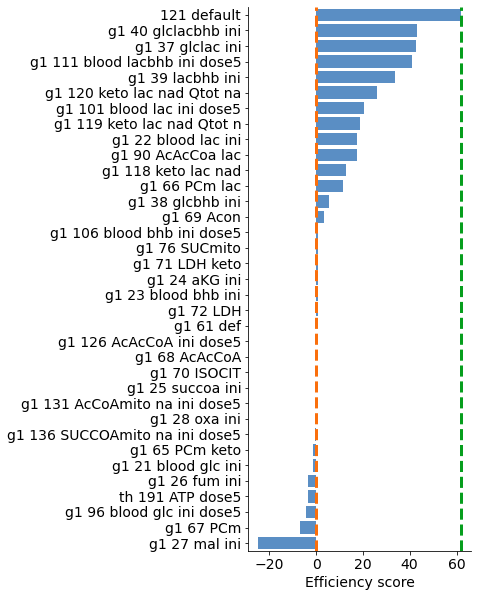

In [29]:
fig = plt.figure(figsize=(4,10))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=therapies_ranking_df, 
            x='score', y='therapy', orient='h',facecolor='#5a8ec4') 
            

plt.axvline(x=0,color='#fa6f0c',lw=3,linestyle='dashed')
plt.axvline(x=therapies_ranking_df.loc[therapies_ranking_df['therapy']=='121 default','score'].values[0],color='#069e1d',lw=3,linestyle='dashed')

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_ylabel("")
ax.set_xlabel("Efficiency score")

plt.show()

if savefigures == True:
    
    spec_id = "fig4b_therapies_barplot_comboMetric_noPDH_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")
